# Regression Model (Data Resampling)

We utilized the SMOTE technique to address the class imbalance in the data by oversampling the minority class. 
In order to estimate the accuracy of a resampled regression model, we created a binary target variable to serve as an auxiliary variable for resampling the training data. The binary target variable was used solely for the purpose of resampling the data and was ignored during the estimation of the root mean squared error (RMSE) for the new resampled dataset.

In [1]:
%load_ext jupyter_black

In [2]:
from collections import defaultdict, Counter
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import colorama
from colorama import Fore

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,1.018526,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# For simplicity in the later steps of the code, I removed last feature from last column and insert it before target
first_column = df.pop("percent_houses_damaged_5years")
df.insert(20, "percent_houses_damaged_5years", first_column)

In [5]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

In [6]:
# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [7]:
# define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,percent_houses_damaged,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,1.018526,...,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.000000,0.0,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.000000,0.0,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.000000,0.0,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.000000,0.0,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,3.790141,...,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.000000,0.0,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,3.532580,...,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.000000,0.0,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,4.444498,...,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.015207,0.0,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,5.816195,...,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.020806,0.0,0


In [8]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)].reset_index(drop=True)
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,percent_houses_damaged,binary_damage
0,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,...,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0.0,0
1,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,...,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0.0,0
2,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,...,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0.0,0
3,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,...,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0.0,0
4,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,...,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0.0,0


In [9]:
# Define bin
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [10]:
# Check the bins' intervalls
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 9e-05]    48685
(9e-05, 1.0]        1069
(1.0, 10.0]            0
(10.0, 50.0]           0
(50.0, 101.0]          0
Name: binary_damage, dtype: int64

In [11]:
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [12]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [13]:
y_input_strat = bin_index2

In [14]:
""" We keep the continuous target in the dataset, since we only want to use binary target to resample dataset and 
after that we will remove it and use continuous target as the main target 
"""
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
    "percent_houses_damaged",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years',
       'percent_houses_damaged'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["binary_damage"], stratify=y_input_strat, test_size=0.2
)

In [16]:
# Check train data before resampling
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [17]:
# Create an oversampled training data
smote = SMOTE()
# random_state=101
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
# Check train data after resampling
print(Counter(y_train))

Counter({0: 38948, 1: 38948})


In [20]:
# Insert X_train into a df
df_train = pd.DataFrame(X_train)
df_train

,wind_speed,track_distance,total_houses,rainfall_max_6h,rainfall_max_24h,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,percent_houses_damaged
0,7.091462,267.564260,1888.035999,7.241667,4.452604,-0.322769,14.272665,7.231711,67.528004,32.019718,396.047333,0.000000,0,0.040000,0.960000,0.000000,12861.061324,0.000000,0.003449
1,4.752962,204.558764,3600.495119,0.795833,0.740625,-0.514833,12.137599,7.983075,60.112006,34.609163,304.289529,0.000000,0,0.230000,0.770000,0.000000,23051.899417,0.000000,0.000000
2,46.597243,6.121964,6433.875299,9.081250,5.507812,-0.186000,3.046346,3.198107,16.860475,14.204030,131.276416,0.000000,0,0.090000,0.910000,0.000000,31042.079993,0.000000,8.057337
3,16.448354,214.405180,15.155830,0.791667,0.286458,-0.622500,15.823127,7.900435,76.502681,34.260587,731.268288,0.000000,0,0.000000,1.000000,0.000000,879.075902,0.000000,0.000000
4,14.153690,261.538266,14023.409634,19.052083,5.804688,0.120800,3.805607,4.080335,18.551360,17.664696,213.776928,0.000000,0,0.540000,0.460000,0.000000,77622.651795,0.353812,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77891,52.184393,43.073901,603.521967,17.185023,7.664748,-0.215479,9.959980,5.449229,46.489727,23.732881,92.608417,9037.678125,1,0.000000,0.097259,0.902741,1833.428817,0.699718,39.686053
77892,59.963897,20.913103,14198.433042,19.667743,10.068214,0.212390,1.664777,2.594430,9.490436,11.775097,22.516089,10176.087806,1,0.632858,0.312375,0.054767,97699.536233,0.176051,12.491949
77893,55.319867,14.517573,4948.324447,34.261990,16.515017,0.230219,3.369494,2.916289,17.850594,14.011837,56.404645,15266.441029,1,0.143589,0.167680,0.688731,22812.874039,0.059657,27.022900
77894,40.940624,3.437480,1077.478451,11.954477,5.602410,-0.596445,6.330113,4.686753,34.260929,20.172359,136.720915,0.000000,0,0.000041,0.999959,0.000000,8119.557321,0.000053,11.232933


In [21]:
# Insert test set into a df
df_test = pd.DataFrame(X_test)
df_test

,wind_speed,track_distance,total_houses,rainfall_max_6h,rainfall_max_24h,rwi,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,percent_houses_damaged
6816,44.048350,61.786077,814.542348,5.829167,2.683854,-0.454500,21.786844,8.494699,106.836137,35.940904,1348.503859,0.000000,0,0.05,0.950000,0.000000,4218.317238,0.000000,0.073563
14330,34.975646,72.507191,17081.650715,5.935417,3.106250,0.098400,1.069686,1.063322,6.487904,4.885841,54.366915,0.000000,0,0.40,0.600000,0.000000,83849.176804,0.000159,0.000000
4035,8.559898,259.887791,6802.568528,5.604167,2.353125,-0.051875,2.987586,4.980522,15.012676,22.327500,90.466566,0.000000,0,0.30,0.700000,0.000000,31044.811399,0.000000,0.000000
46217,8.608691,69.435436,2844.830584,4.158333,3.081250,-0.213333,0.582979,0.373018,4.351621,1.966492,4.763869,9627.413274,1,0.08,0.000000,0.920000,20552.931756,0.048214,0.000000
3920,16.340823,2.839519,16065.139352,10.943750,6.406771,0.102920,0.891633,0.762243,5.746411,3.327205,23.140974,0.000000,0,0.56,0.440000,0.000000,73292.845633,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,23.048018,218.276908,5647.655383,5.081250,3.626562,-0.469800,8.637702,7.042663,42.553258,31.234748,342.079981,0.000000,0,0.19,0.810000,0.000000,36805.207329,0.000000,0.000000
7914,13.740308,299.626696,2363.977108,1.277083,0.690104,0.103750,3.299979,4.458310,17.104493,20.096613,23.764076,13312.672371,1,0.16,0.130000,0.710000,23067.075843,0.000000,0.000000
34101,9.093119,288.706071,1056.625095,0.554167,0.228646,-0.308857,8.594823,6.453575,42.721060,28.579737,50.229820,29180.717993,1,0.01,0.270000,0.720000,8824.907015,0.002958,0.000000
39677,52.629388,23.155755,1653.440526,8.487500,5.494792,-0.068800,9.129843,5.777991,45.061471,24.800281,82.043315,36086.646548,1,0.00,0.290909,0.709091,9664.064570,0.522671,0.000000


Text(0.5, 1.0, 'percent_houses_damaged for test_data')

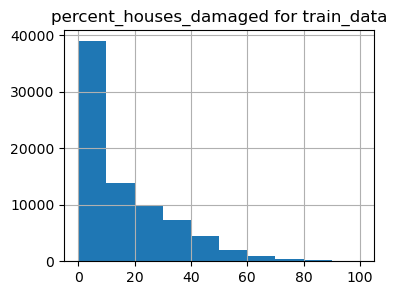

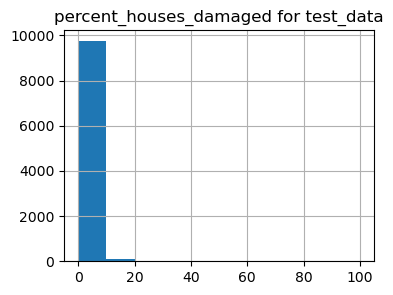

In [22]:
# Show histogram of damage for train data
df_train.hist(column="percent_houses_damaged", figsize=(4, 3))
plt.title("percent_houses_damaged for train_data")

# Show histogram of damage for test data
df_test.hist(column="percent_houses_damaged", figsize=(4, 3))
plt.title("percent_houses_damaged for test_data")

In [24]:
# We use this features to train regression model
features_new = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

In [25]:
# Split X and y from train dataframe
X_train = df_train[features_new]
display(X_train.columns)
y_train = df_train["percent_houses_damaged"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [26]:
# Split X and y from test dataframe
X_test = df_test[features_new]
display(X_test.columns)
y_test = df_test["percent_houses_damaged"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [27]:
sc = preprocessing.StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [28]:
X_train = X_train_sc
X_test = X_test_sc
y_train = y_train
y_test = y_test

In [29]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

X2_test = sm.add_constant(X_test)

y_pred_train_LREG = est2.predict(X2)
mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

ypred_LREG = est2.predict(X2_test)
mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
rmse_LREG = np.sqrt(mse_idx_LREG)


print(f"LREG Root mean squared error(training): {rmse_train_LREG:.2f}")
print(f"LREG Root mean squared error(test): {rmse_LREG:.2f}")


# Calculate RMSE in total

y_pred_train = xgb.predict(X_train)

# Clip the predicted values to be within the range of zero to 100
y_pred_train_clipped = y_pred_train.clip(0, 100)
mse_train_idx = mean_squared_error(y_train, y_pred_train_clipped)
rmse_train = np.sqrt(mse_train_idx)


y_pred = xgb.predict(X_test)

# Clip the predicted values to be within the range of zero to 100
y_pred_clipped = y_pred.clip(0, 100)
mse_idx = mean_squared_error(y_test, y_pred_clipped)
rmse = np.sqrt(mse_idx)

print(f"RMSE_train_in_total: {rmse_train:.2f}")
print(f"RMSE_test_in_total: {rmse:.2f}")


# Calculate RMSE per bins

bin_index_test = np.digitize(y_test, bins=binsP2)
bin_index_train = np.digitize(y_train, bins=binsP2)


for bin_num in range(1, 6):

    # Estimation of RMSE for train data
    mse_train_idx = mean_squared_error(
        y_train[bin_index_train == bin_num],
        y_pred_train_clipped[bin_index_train == bin_num],
    )
    rmse_train = np.sqrt(mse_train_idx)

    # Estimation of RMSE for test data
    mse_idx = mean_squared_error(
        y_test[bin_index_test == bin_num], y_pred_clipped[bin_index_test == bin_num]
    )
    rmse = np.sqrt(mse_idx)

    print(f"RMSE_train: {rmse_train:.2f}")
    print(f"RMSE_test: {rmse:.2f}")

[21:51:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.616
Model:                                OLS   Adj. R-squared:                  0.616
Method:                     Least Squares   F-statistic:                     7356.
Date:                    Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                            21:51:22   Log-Likelihood:            -2.9724e+05
No. Observations:                   77896   AIC:                 